In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import applications
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB7, preprocess_input
from tensorflow.keras import Input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from pickle import dump, load
from PIL import Image
from tqdm import tqdm
tqdm().pandas()
from google.cloud import storage
import os

0it [00:00, ?it/s]


In [66]:
# Initialise a client
storage_client = storage.Client("wagon-bootcamp-415720")
# Create a bucket object for our bucket
bucket = storage_client.get_bucket('covid19_lewagon')
# Create a blob object from the filepath
#blob = bucket.blob("COVID-19_Radiography_Dataset/Covid/*")


In [154]:
blob = bucket.blob("COVID-19_Radiography_Dataset/Normal/Normal-1.png")
blob.bucket.name + '/' + blob.name

'covid19_lewagon/COVID-19_Radiography_Dataset/Normal/Normal-1.png'

In [75]:
covid1_names = []

for blob in bucket.list_blobs(prefix='xray-dataset-covid-pneumonia/Covid19 (1)/'):
    #normal_names.append(blob.name[36:])
    covid1_names.append(blob.name)
#covid1_names[:5]
len(covid1_names)

460

In [79]:
covid2_names = []

for blob in bucket.list_blobs(prefix='xray-dataset-covid-pneumonia/Covid19 (2)/'):
    #normal_names.append(blob.name[36:])
    covid2_names.append(blob.name)
#covid1_names[:5]
len(covid2_names)
#covid2_names[:5]

243

In [77]:
pneumonia2_names = []

for blob in bucket.list_blobs(prefix='xray-dataset-covid-pneumonia/Pneumonia/'):
    #normal_names.append(blob.name[36:])
    pneumonia2_names.append(blob.name)
#covid1_names[:5]
len(pneumonia2_names)
pneumonia2_names[:5]

3418

In [70]:
covid_names = []
for blob in bucket.list_blobs(prefix='COVID-19_Radiography_Dataset/COVID/'):
    #normal_names.append(blob.name[36:])
    covid_names.append(blob.name)
covid_names[:5]

['COVID-19_Radiography_Dataset/COVID/COVID-1.png',
 'COVID-19_Radiography_Dataset/COVID/COVID-10.png',
 'COVID-19_Radiography_Dataset/COVID/COVID-100.png',
 'COVID-19_Radiography_Dataset/COVID/COVID-1000.png',
 'COVID-19_Radiography_Dataset/COVID/COVID-1001.png']

In [68]:
normal_names = []
for blob in bucket.list_blobs(prefix='COVID-19_Radiography_Dataset/Normal/'):
    #normal_names.append(blob.name[36:])
    normal_names.append(blob.name)
normal_names[:5]

['COVID-19_Radiography_Dataset/Normal/Normal-1.png',
 'COVID-19_Radiography_Dataset/Normal/Normal-10.png',
 'COVID-19_Radiography_Dataset/Normal/Normal-100.png',
 'COVID-19_Radiography_Dataset/Normal/Normal-1000.png',
 'COVID-19_Radiography_Dataset/Normal/Normal-10000.png']

In [71]:
pneumonia_names = []
for blob in bucket.list_blobs(prefix='COVID-19_Radiography_Dataset/Viral Pneumonia/'):
    #pneumonia_names.append(blob.name[45:])
    pneumonia_names.append(blob.name)
pneumonia_names[:5]

['COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1.png',
 'COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-10.png',
 'COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-100.png',
 'COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1000.png',
 'COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1001.png']

In [72]:
opacity_names = []
for blob in bucket.list_blobs(prefix='COVID-19_Radiography_Dataset/Lung_Opacity/'):
    #opacity_names.append(blob.name[42:])
    opacity_names.append(blob.name)
opacity_names[:5]

['COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1.png',
 'COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-10.png',
 'COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-100.png',
 'COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1000.png',
 'COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1001.png']

In [73]:
print(len(covid_names))
print(len(normal_names))
print(len(pneumonia_names))
print(len(opacity_names))
print(len(covid_names)+len(normal_names)+len(pneumonia_names)+len(opacity_names))

3616
10192
1345
6012
21165


In [9]:
import random
random.shuffle(covid_names)
random.shuffle(normal_names)
random.shuffle(pneumonia_names)
random.shuffle(opacity_names)
train_covid_names, test_covid_names = train_test_split(covid_names, test_size=0.20, random_state=42)
train_normal_names, test_normal_names = train_test_split(normal_names, test_size=0.20, random_state=42)
train_pneumonia_names, test_pneumonia_names = train_test_split(pneumonia_names, test_size=0.20, random_state=42)
train_opacity_names, test_opacity_names = train_test_split(opacity_names, test_size=0.20, random_state=42)

In [10]:
print(len(train_covid_names), len(test_covid_names))
print(len(train_normal_names), len(test_normal_names))
print(len(train_pneumonia_names), len(test_pneumonia_names))
print(len(train_opacity_names), len(test_opacity_names))

2892 724
8153 2039
1076 269
4809 1203


#Data Visualization

In [ ]:
covid19_lewagon/COVID-19_Radiography_Dataset/COVID

COVID-19_Radiography_Dataset/COVID/COVID-1197.png

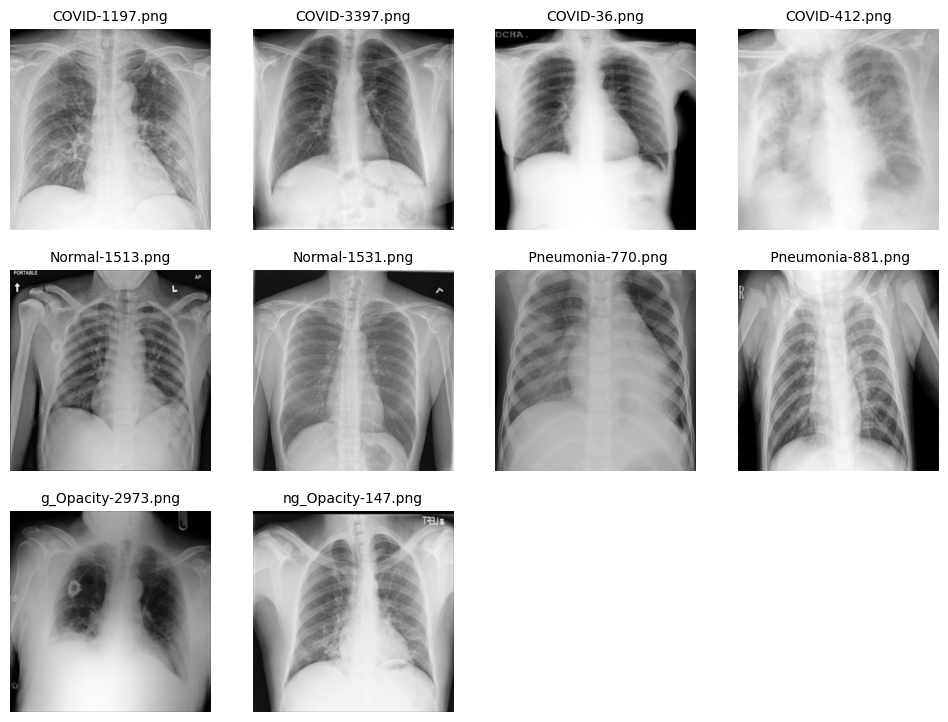

In [161]:
# plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
import matplotlib.image as mpimg
from PIL import Image
#from PIL import Image
import requests
from io import BytesIO
import urllib.request
from PIL import Image
from urllib.request import urlopen
import PIL
from skimage import io
from io import StringIO

#set the number of columns and rows
rows = 4
cols = 4

#set the figure size
fig = plt.gcf()
fig.set_size_inches(12,12)

#merge the covid and normal list
merged_list = train_covid_names[0:4]+train_normal_names[0:2]+train_pneumonia_names[0:2]+train_opacity_names[0:2]
#merged_list = covid_pic+normal_pic+pneumonia_pic+opacity_pic
for i, img_path in enumerate(merged_list):
    #print(img_path.split("/", 6)[-1])
    #print('covid19_lewagon' + '/' + img_path)


    data = img_path.split("/",6)[-1]
    sp = plt.subplot(rows, cols, i+1)
    sp.axis("off")

    #img = mpimg.imread('gs://covid19_lewagon' + '/' + img_path)
    sp.set_title(data[-18:], fontsize=10)
    #plt.imshow(img, cmap="gray")

    #gs://covid19_lewagon/COVID-19_Radiography_Dataset/COVID/COVID-1.png
    #https://storage.googleapis.com/covid19_lewagon/COVID-19_Radiography_Dataset/COVID/COVID-1002.png
    #https://storage.cloud.google.com/covid19_lewagon/COVID-19_Radiography_Dataset/COVID/COVID-1001.png

    img = f"https://storage.googleapis.com/covid19_lewagon/{img_path}"
    response = requests.get(img)
    img = Image.open(BytesIO(response.content))
    #img = mpimg.imread(response)
    sp.set_title(data[-18:], fontsize=10)
    plt.imshow(img, cmap="gray")


plt.show()

In [153]:
urllib.request.urlretrieve(
  'https://storage.googleapis.com/covid19_lewagon/COVID-19_Radiography_Dataset/COVID/COVID-1.png',
   "COVID-1.png")

img = Image.open("COVID-1.png")
img.show()

In [ ]:

main_dir = "/content/drive/My Drive/data/viral/COVID-19_Radiography_Dataset/"
covid = os.path.join(main_dir, "COVID")
normal = os.path.join(main_dir, "Normal")
pneumonia = os.path.join(main_dir, "Viral Pneumonia")
opacity = os.path.join(main_dir, "Lung_Opacity")

In [ ]:
covid_names = os.listdir(covid)
normal_names = os.listdir(normal)
pneumonia_names = os.listdir(pneumonia)
opacity_names = os.listdir(opacity)

In [ ]:
print(len(covid_names))
print(len(normal_names))
print(len(pneumonia_names))
print(len(opacity_names))
print(len(covid_names)+len(normal_names)+len(pneumonia_names)+len(opacity_names))

In [ ]:
print(covid_names[:10])
print(normal_names[:10])
print(pneumonia_names[:10])
print(opacity_names[:10])